# Datalab: A unified audit to detect all kinds of issues in data and labels

Cleanlab offers a `Datalab` object that can identify various issues in your machine learning datasets, such as noisy labels, outliers, (near) duplicates, drift, and other types of problems common in real-world data. These data issues may negatively impact models if not addressed. `Datalab` utilizes *any* ML model you have already trained for your data to diagnose these issues, it only requires access to either: (probabilistic) predictions from your model or its learned representations of the data.


**Overview of what we'll do in this tutorial:**

- Compute out-of-sample predicted probabilities for a sample dataset using cross-validation.
- Use `Datalab` to identify issues such as noisy labels, outliers, (near) duplicates, and other types of problems 
- View the issue summaries and other information about our sample dataset

You can easily replace our demo dataset with your own image/text/tabular/audio/etc dataset, and then run the same code to discover what sort of issues lurk within it!

<div class="alert alert-info">
Quickstart
<br/>
    
Already have (out-of-sample) `pred_probs` from a model trained on an existing set of labels? Maybe you also have some numeric `features` (or model embeddings of data)? Run the code below to examine your dataset for multiple types of issues.

<div  class=markdown markdown="1" style="background:white;margin:16px">  
    
```ipython3 
from cleanlab import Datalab

lab = Datalab(data=your_dataset, label_name="column_name_of_labels")
lab.find_issues(features=your_feature_matrix, pred_probs=your_pred_probs)

lab.report()
```
   
</div>
</div>

## 1. Install and import required dependencies

`Datalab` has additional dependencies that are not included in the standard installation of cleanlab.

You can use pip to install all packages required for this tutorial as follows:

```ipython3
!pip install matplotlib
!pip install "cleanlab[datalab]"

# Make sure to install the version corresponding to this tutorial
# E.g. if viewing master branch documentation:
#     !pip install git+https://github.com/cleanlab/cleanlab.git
```

In [1]:
# Package installation (hidden on docs website).
dependencies = ["cleanlab", "matplotlib", "datasets"]  # TODO: make sure this list is updated

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install cleanlab  # for colab
    cmd = ' '.join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    dependencies_test = [dependency.split('>')[0] if '>' in dependency 
                         else dependency.split('<')[0] if '<' in dependency 
                         else dependency.split('=')[0] for dependency in dependencies]
    missing_dependencies = []
    for dependency in dependencies_test:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

/home/rahul/anaconda3/envs/super/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

from cleanlab import Datalab

## 2. Create and load the data (can skip these details)

We'll load a toy classification dataset for this tutorial. The dataset has two numerical features and a label column with three possible classes. Each example is classified as either: *low*, *mid* or *high*.

<details><summary>See the code for data generation. **(click to expand)**</summary>
    
```ipython3
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

from sklearn.model_selection import train_test_split
from cleanlab.benchmarking.noise_generation import (
    generate_noise_matrix_from_trace,
    generate_noisy_labels,
)

SEED = 123
np.random.seed(SEED)

BINS = {
    "low": [-np.inf, 3.3],
    "mid": [3.3, 6.6],
    "high": [6.6, +np.inf],
}

BINS_MAP = {
    "low": 0,
    "mid": 1,
    "high": 2,
}


def create_data():

    X = np.random.rand(250, 2) * 5
    y = np.sum(X, axis=1)
    # Map y to bins based on the BINS dict
    y_bin = np.array([k for y_i in y for k, v in BINS.items() if v[0] <= y_i < v[1]])
    y_bin_idx = np.array([BINS_MAP[k] for k in y_bin])

    # Split into train and test
    X_train, X_test, y_train, y_test, y_train_idx, y_test_idx = train_test_split(
        X, y_bin, y_bin_idx, test_size=0.5, random_state=SEED
    )

    # Add several (5) out-of-distribution points. Sliding them along the decision boundaries
    # to make them look like they are out-of-frame
    X_out = np.array(
        [
            [-1.5, 3.0],
            [-1.75, 6.5],
            [1.5, 7.2],
            [2.5, -2.0],
            [5.5, 7.0],
        ]
    )
    # Add a near duplicate point to the last outlier, with some tiny noise added
    near_duplicate = X_out[-1:] + np.random.rand(1, 2) * 1e-6
    X_out = np.concatenate([X_out, near_duplicate])

    y_out = np.sum(X_out, axis=1)
    y_out_bin = np.array([k for y_i in y_out for k, v in BINS.items() if v[0] <= y_i < v[1]])
    y_out_bin_idx = np.array([BINS_MAP[k] for k in y_out_bin])

    # Add to train
    X_train = np.concatenate([X_train, X_out])
    y_train = np.concatenate([y_train, y_out])
    y_train_idx = np.concatenate([y_train_idx, y_out_bin_idx])

    # Add an exact duplicate example to the training set
    exact_duplicate_idx = np.random.randint(0, len(X_train))
    X_duplicate = X_train[exact_duplicate_idx, None]
    y_duplicate = y_train[exact_duplicate_idx, None]
    y_duplicate_idx = y_train_idx[exact_duplicate_idx, None]

    # Add to train
    X_train = np.concatenate([X_train, X_duplicate])
    y_train = np.concatenate([y_train, y_duplicate])
    y_train_idx = np.concatenate([y_train_idx, y_duplicate_idx])

    py = np.bincount(y_train_idx) / float(len(y_train_idx))
    m = len(BINS)

    noise_matrix = generate_noise_matrix_from_trace(
        m,
        trace=0.9 * m,
        py=py,
        valid_noise_matrix=True,
        seed=SEED,
    )

    noisy_labels_idx = generate_noisy_labels(y_train_idx, noise_matrix)
    noisy_labels = np.array([list(BINS_MAP.keys())[i] for i in noisy_labels_idx])

    return X_train, y_train_idx, noisy_labels, noisy_labels_idx, X_out, X_duplicate
```

</details>

In [5]:
from sklearn.model_selection import train_test_split
from cleanlab.benchmarking.noise_generation import (
    generate_noise_matrix_from_trace,
    generate_noisy_labels,
)

SEED = 123
np.random.seed(SEED)

BINS = {
    "low": [-np.inf, 3.3],
    "mid": [3.3, 6.6],
    "high": [6.6, +np.inf],
}

BINS_MAP = {
    "low": 0,
    "mid": 1,
    "high": 2,
}


def create_data():

    X = np.random.rand(250, 2) * 5
    y = np.sum(X, axis=1)
    # Map y to bins based on the BINS dict
    y_bin = np.array([k for y_i in y for k, v in BINS.items() if v[0] <= y_i < v[1]])
    y_bin_idx = np.array([BINS_MAP[k] for k in y_bin])

    # Split into train and test
    X_train, X_test, y_train, y_test, y_train_idx, y_test_idx = train_test_split(
        X, y_bin, y_bin_idx, test_size=0.5, random_state=SEED
    )

    # Add several (5) out-of-distribution points. Sliding them along the decision boundaries
    # to make them look like they are out-of-frame
    X_out = np.array(
        [
            [-1.5, 3.0],
            [-1.75, 6.5],
            [1.5, 7.2],
            [2.5, -2.0],
            [5.5, 7.0],
        ]
    )
    # Add a near duplicate point to the last outlier, with some tiny noise added
    near_duplicate = X_out[-1:] + np.random.rand(1, 2) * 1e-6
    X_out = np.concatenate([X_out, near_duplicate])

    y_out = np.sum(X_out, axis=1)
    y_out_bin = np.array([k for y_i in y_out for k, v in BINS.items() if v[0] <= y_i < v[1]])
    y_out_bin_idx = np.array([BINS_MAP[k] for k in y_out_bin])

    # Add to train
    X_train = np.concatenate([X_train, X_out])
    y_train = np.concatenate([y_train, y_out])
    y_train_idx = np.concatenate([y_train_idx, y_out_bin_idx])

    # Add an exact duplicate example to the training set
    exact_duplicate_idx = np.random.randint(0, len(X_train))
    X_duplicate = X_train[exact_duplicate_idx, None]
    y_duplicate = y_train[exact_duplicate_idx, None]
    y_duplicate_idx = y_train_idx[exact_duplicate_idx, None]

    # Add to train
    X_train = np.concatenate([X_train, X_duplicate])
    y_train = np.concatenate([y_train, y_duplicate])
    y_train_idx = np.concatenate([y_train_idx, y_duplicate_idx])

    py = np.bincount(y_train_idx) / float(len(y_train_idx))
    m = len(BINS)

    noise_matrix = generate_noise_matrix_from_trace(
        m,
        trace=0.9 * m,
        py=py,
        valid_noise_matrix=True,
        seed=SEED,
    )

    noisy_labels_idx = generate_noisy_labels(y_train_idx, noise_matrix)
    noisy_labels = np.array([list(BINS_MAP.keys())[i] for i in noisy_labels_idx])
    # Assign few datapoints to rare class
    random_idx = np.random.randint(0, X_train.shape[0], 3)
    noisy_labels[random_idx] = "max"
    noisy_labels_idx[random_idx] = np.max(y_bin_idx) + 1
    

    return X_train, y_train_idx, noisy_labels, noisy_labels_idx, X_out, X_duplicate

In [6]:
X_train, y_train_idx, noisy_labels, noisy_labels_idx, X_out, X_duplicate = create_data()

We make a scatter plot of the features, with a color corresponding to the observed labels. Incorrect given labels are highlighted in red if they do not match the true label, outliers highlighted with an a black cross, and duplicates highlighted with a cyan cross.

<details><summary>See the code to visualize the data. **(click to expand)**</summary>
    
```ipython3
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

import matplotlib.pyplot as plt

def plot_data(X_train, y_train_idx, noisy_labels_idx, X_out, X_duplicate):
    # Plot data with clean labels and noisy labels, use BINS_MAP for the legend
    fig, ax = plt.subplots(figsize=(8, 6.5))
        
    low = ax.scatter(X_train[noisy_labels_idx == 0, 0], X_train[noisy_labels_idx == 0, 1], label="low")
    mid = ax.scatter(X_train[noisy_labels_idx == 1, 0], X_train[noisy_labels_idx == 1, 1], label="mid")
    high = ax.scatter(X_train[noisy_labels_idx == 2, 0], X_train[noisy_labels_idx == 2, 1], label="high")
    
    ax.set_title("Noisy labels")
    ax.set_xlabel(r"$x_1$", fontsize=16)
    ax.set_ylabel(r"$x_2$", fontsize=16)

    # Plot true boundaries (x+y=3.3, x+y=6.6)
    ax.set_xlim(-3.5, 9.0)
    ax.set_ylim(-3.5, 9.0)
    ax.plot([-0.7, 4.0], [4.0, -0.7], color="k", linestyle="--", alpha=0.5)
    ax.plot([-0.7, 7.3], [7.3, -0.7], color="k", linestyle="--", alpha=0.5)

    # Draw red circles around the points that are misclassified (i.e. the points that are in the wrong bin)
    for i, (X, y) in enumerate(zip([X_train, X_train], [y_train_idx, noisy_labels_idx])):
        for j, (k, v) in enumerate(BINS_MAP.items()):
            label_err = ax.scatter(
                X[(y == v) & (y != y_train_idx), 0],
                X[(y == v) & (y != y_train_idx), 1],
                s=180,
                marker="o",
                facecolor="none",
                edgecolors="red",
                linewidths=2.5,
                alpha=0.5,
                label="Label error",
            )


    outlier = ax.scatter(X_out[:, 0], X_out[:, 1], color="k", marker="x", s=100, linewidth=2, label="Outlier")

    # Plot the exact duplicate
    dups = ax.scatter(
        X_duplicate[:, 0],
        X_duplicate[:, 1],
        color="c",
        marker="x",
        s=100,
        linewidth=2,
        label="Duplicates",
    )
    
    first_legend = ax.legend(handles=[low, mid, high], loc=[0.75, 0.7], title="Given Class Label", alignment="left", title_fontproperties={"weight":"semibold"})
    second_legend = ax.legend(handles=[label_err, outlier, dups], loc=[0.75, 0.45], title="Type of Issue", alignment="left", title_fontproperties={"weight":"semibold"})
    
    ax = plt.gca().add_artist(first_legend)
    ax = plt.gca().add_artist(second_legend)
    plt.tight_layout()
```
    
</details>

In [11]:
import matplotlib.pyplot as plt

def plot_data(X_train, y_train_idx, noisy_labels_idx, X_out, X_duplicate):
    # Plot data with clean labels and noisy labels, use BINS_MAP for the legend
    fig, ax = plt.subplots(figsize=(6, 4))
        
    low = ax.scatter(X_train[noisy_labels_idx == 0, 0], X_train[noisy_labels_idx == 0, 1], label="low")
    mid = ax.scatter(X_train[noisy_labels_idx == 1, 0], X_train[noisy_labels_idx == 1, 1], label="mid")
    high = ax.scatter(X_train[noisy_labels_idx == 2, 0], X_train[noisy_labels_idx == 2, 1], label="high")
    
    ax.set_title("Noisy labels")
    ax.set_xlabel(r"$x_1$", fontsize=16)
    ax.set_ylabel(r"$x_2$", fontsize=16)

    # Plot true boundaries (x+y=3.3, x+y=6.6)
    ax.set_xlim(-2.5, 8.5)
    ax.set_ylim(-3.5, 9.0)
    ax.plot([-0.7, 4.0], [4.0, -0.7], color="k", linestyle="--", alpha=0.5)
    ax.plot([-0.7, 7.3], [7.3, -0.7], color="k", linestyle="--", alpha=0.5)

    # Draw red circles around the points that are misclassified (i.e. the points that are in the wrong bin)
    for i, (X, y) in enumerate(zip([X_train, X_train], [y_train_idx, noisy_labels_idx])):
        for j, (k, v) in enumerate(BINS_MAP.items()):
            label_err = ax.scatter(
                X[(y == v) & (y != y_train_idx), 0],
                X[(y == v) & (y != y_train_idx), 1],
                s=180,
                marker="o",
                facecolor="none",
                edgecolors="red",
                linewidths=2.5,
                alpha=0.5,
                label="Label error",
            )


    outlier = ax.scatter(X_out[:, 0], X_out[:, 1], color="k", marker="x", s=100, linewidth=2, label="Outlier")

    # Plot the exact duplicate
    dups = ax.scatter(
        X_duplicate[:, 0],
        X_duplicate[:, 1],
        color="c",
        marker="x",
        s=100,
        linewidth=2,
        label="Duplicates",
    )
    
    title_fontproperties = {"weight":"semibold", "size": 8}
    first_legend = ax.legend(handles=[low, mid, high], loc=[0.76, 0.7], title="Given Class Label", alignment="left", title_fontproperties=title_fontproperties, fontsize=8, markerscale=0.5)
    second_legend = ax.legend(handles=[label_err, outlier, dups], loc=[0.76, 0.46], title="Type of Issue", alignment="left", title_fontproperties=title_fontproperties, fontsize=8, markerscale=0.5)
    
    ax = plt.gca().add_artist(first_legend)
    ax = plt.gca().add_artist(second_legend)
    plt.tight_layout()

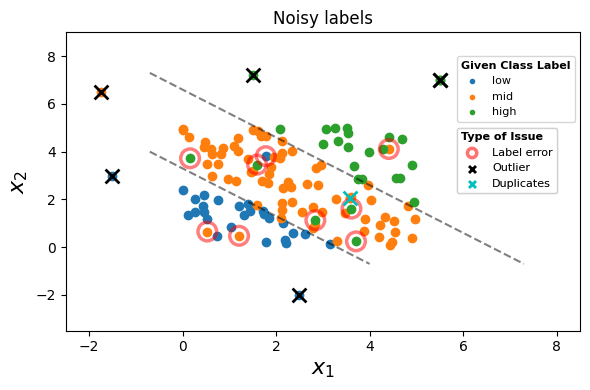

In [12]:
plot_data(X_train, y_train_idx, noisy_labels_idx, X_out, X_duplicate)

In real-world scenarios, you won't know the true labels or the distribution of the features, so we won't use these in this tutorial, except for evaluation purposes.



`Datalab` has several ways of loading the data.
In this case, we'll simply wrap the training features and noisy labels in a dictionary so that we can pass it to `Datalab`.

In [16]:
data = {"X": X_train, "y": noisy_labels}

Other supported data formats for `Datalab` include: [HuggingFace Datasets](https://huggingface.co/docs/datasets/index) and [pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html). `Datalab` works across most data modalities (image, text, tabular, audio, etc). It is intended to find issues that commonly occur in datasets for which you have trained a supervised ML model, regardless of the type of data.

Currently, pandas DataFrames that contain categorical columns might cause some issues when instantiating the `Datalab` object, so it is recommended to ensure that your DataFrame does not contain any categorical columns, or use other data formats (eg. python dictionary, HuggingFace Datasets) to pass in your data.

## 3. Get out-of-sample predicted probabilities from a classifier

To detect certain types of issues in classification data (e.g. label errors), `Datalab` relies on predicted class probabilities from a trained model. Ideally, the prediction for each example should be out-of-sample (to avoid overfitting), coming from a copy of the model that was not trained on this example. 

This tutorial uses a simple logistic regression model 
and the `cross_val_predict()` function from scikit-learn to generate out-of-sample predicted class probabilities for every example in the training set. You can replace this with *any* other classifier model and train it with cross-validation to get out-of-sample predictions.
Make sure that the columns of your `pred_probs` are properly ordered with respect to the ordering of classes, which for Datalab is: lexicographically sorted by class name.

In [17]:
model = LogisticRegression()
pred_probs = cross_val_predict(
    estimator=model, X=data["X"], y=data["y"], cv=5, method="predict_proba"
)

/home/rahul/anaconda3/envs/super/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


## 4. Use Datalab to find issues in the dataset

We create a `Datalab` object from the dataset, also providing the name of the label column in the dataset. Only instantiate one `Datalab` object per dataset, and note that only classification datasets are supported for now.

All that is need to audit your data is to call `find_issues()`.
This method accepts various inputs like: predicted class probabilities, numeric feature representations of the data. The more information you provide here, the more thoroughly `Datalab` will audit your data! Note that `features` should be some numeric representation of each example, either obtained through preprocessing transformation of your raw data or embeddings from a (pre)trained model. In this case, our data is already entirely numeric so we just provide the features directly.

In [18]:
lab = Datalab(data, label_name="y")
lab.find_issues(pred_probs=pred_probs, features=data["X"])

Finding null issues ...
Finding label issues ...


/home/rahul/anaconda3/envs/super/lib/python3.9/site-packages/cleanlab/filter.py:904: UserWarning: May not flag all label issues in class: 2, it has too few examples (see `min_examples_per_class` argument)
  warnings.warn(


Finding outlier issues ...
Fitting OOD estimator based on provided features ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 30 issues found in the dataset.


Now let's review the results of this audit using `report()`.
This provides a high-level summary of each type of issue found in the dataset.

In [19]:
lab.report()

Here is a summary of the different kinds of issues found in the data:

     issue_type  num_issues
          label          17
        outlier           6
 near_duplicate           4
class_imbalance           3

Dataset Information: num_examples: 132, num_classes: 4


----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potentially incorrect
    (e.g. due to annotation error) are flagged as having label issues.
    

Number of examples with this issue: 17
Overall dataset quality in terms of this issue: 0.8561

Examples representing most severe instances of this issue:
     is_label_issue  label_score given_label predicted_label
77            False     0.001908         max             mid
58            False     0.003564         max            high
8             False     0.007331         max             mid
7              True     0.008963         low             mid
120            True     0.009664        high  

## 5. Learn more about the issues in your dataset

Datalab detects all sorts of issues in a dataset and what to do with the findings will vary case-by-case. For automated improvement of a dataset via best practices to handle auto-detected issues, try [Cleanlab Studio](https://cleanlab.ai/?utm_source=internal&utm_medium=blog&utm_campaign=clostostudio).

To conceptually understand how each type of issue is defined and what it means if detected in your data, check out the [Issue Type Descriptions](../../cleanlab/datalab/guide/issue_type_description.html) page. The [Datalab Issue Types](https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html) page also lists additional types of issues that `Datalab.find_issues()` can detect, as well as optional parameters you can specify for greater control over how your data are checked.

Datalab offers several methods to understand more details about a particular issue in your dataset.
The `get_issue_summary()` method fetches summary statistics regarding how severe each type of issue is overall across the whole dataset.

In [20]:
lab.get_issue_summary()

,issue_type,score,num_issues
0,null,1.000000,0
1,label,0.856061,17
2,outlier,0.355772,6
3,near_duplicate,0.616034,4
4,non_iid,0.821750,0
5,class_imbalance,0.022727,3
6,underperforming_group,0.901562,0


In the returned summary DataFrame: LOWER `score` values indicate types of issues that are MORE severe *overall* across the dataset (lower-quality data in terms of this issue), HIGHER `num_issues` values indicate types of issues that are MORE severe *overall* across the dataset (more datapoints appear to exhibit this issue).

We can also only request the summary for a particular type of issue.

In [21]:
lab.get_issue_summary("label")

,issue_type,score,num_issues
0,label,0.856061,17


The `get_issues()` method returns information for each *individual example* in the dataset including: whether or not it is plagued by this issue (Boolean), as well as a *quality score* (numeric value betweeen 0 to 1) quantifying how severe this issue appears to be for this particular example.

In [22]:
lab.get_issues().head()

,is_null_issue,null_score,is_label_issue,label_score,is_outlier_issue,outlier_score,is_near_duplicate_issue,near_duplicate_score,is_non_iid_issue,non_iid_score,is_class_imbalance_issue,class_imbalance_score,is_underperforming_group_issue,underperforming_group_score
0,False,1.0,False,0.859131,False,0.417707,False,0.664083,False,0.970324,False,1.0,False,1.0
1,False,1.0,False,0.816953,False,0.375317,False,0.641516,False,0.890575,False,1.0,False,1.0
2,False,1.0,False,0.531021,False,0.460593,False,0.601188,False,0.826147,False,1.0,False,1.0
3,False,1.0,False,0.752808,False,0.321635,False,0.562539,False,0.948362,False,1.0,False,1.0
4,False,1.0,True,0.090243,False,0.472909,False,0.746763,False,0.878267,False,1.0,False,1.0


In [23]:
issue_types = lab.get_issue_summary()["issue_type"].tolist()
issue_types

['null',
 'label',
 'outlier',
 'near_duplicate',
 'non_iid',
 'class_imbalance',
 'underperforming_group']

In [24]:
issue_results = lab.get_issues("label")
issue_results[issue_results["is_label_issue"] == True]

,is_label_issue,label_score,given_label,predicted_label
4,True,0.090243,high,mid
7,True,0.008963,low,mid
18,True,0.376309,high,mid
20,True,0.440594,low,mid
40,True,0.013445,mid,low
43,True,0.119473,high,mid
53,True,0.026376,high,mid
54,True,0.035663,mid,low
84,True,0.435992,low,mid
91,True,0.403268,high,mid


In [25]:
outlier_results = lab.get_issues("outlier")
outlier_results[outlier_results["is_outlier_issue"] == True]

,is_outlier_issue,outlier_score
125,True,0.036098
126,True,0.006636
127,True,0.014909
128,True,0.017443
129,True,0.012571
130,True,0.012571


In [26]:
duplicate_results = lab.get_issues("near_duplicate")
duplicate_results[duplicate_results["is_near_duplicate_issue"] == True]

,is_near_duplicate_issue,near_duplicate_score,near_duplicate_sets,distance_to_nearest_neighbor
123,True,0.000000,[131],0.000000e+00
129,True,0.000002,[130],4.463180e-07
130,True,0.000002,[129],4.463180e-07
131,True,0.000000,[123],0.000000e+00


In [27]:
def jaccard_similarity(l1, l2):
    s1 = set(l1)
    s2 = set(l2)
    intersect_set = s1.intersection(s2)
    union_set = s1.union(s2)
    if len(intersect_set) == 0:
        return 0
    return len(intersect_set) / len(union_set)

In [28]:
identified_label_issues_indices

[4, 7, 18, 20, 40, 43, 53, 54, 84, 91, 96, 98, 104, 105, 107, 115, 120]

In [29]:
label_issue_indices

[4,
 7,
 8,
 18,
 20,
 22,
 40,
 43,
 53,
 54,
 58,
 77,
 78,
 84,
 91,
 96,
 98,
 104,
 105,
 107,
 115,
 120]

In [35]:
def indices_of_mismatch(list1, list2):
    # Return indices where elements are not the same in both lists
    return [index for index, (elem1, elem2) in enumerate(zip(list1, list2)) if elem1 != elem2]

# Example lists
# Get indices where the lists are not the same
mismatch_indices = indices_of_mismatch(y_train_idx, noisy_labels_idx)

print("Indices where lists are not the same:", mismatch_indices)


Indices where lists are not the same: [4, 7, 8, 40, 43, 53, 54, 58, 77, 105, 107, 120]


In [30]:
print(jaccard_similarity(identified_label_issues_indices, label_issue_indices))
print(jaccard_similarity(identified_outlier_issues_indices, outlier_issue_indices))
print(jaccard_similarity(identified_duplicate_issues_indices, duplicate_issue_indices))

0.7727272727272727
1.0
1.0


123

In [47]:
# Note: This cell is only for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.
from sklearn.metrics import roc_auc_score

identified_label_issues_indices = issue_results[issue_results["is_label_issue"] == True].index.tolist()
label_issue_indices = issue_results[issue_results["given_label"] != issue_results["predicted_label"]].index.tolist()

label_quality_scores = issue_results["label_score"].tolist()
Z = (issue_results['given_label'] == issue_results['predicted_label']).astype(float).tolist()
roc_auc_label = roc_auc_score(Z, label_quality_scores)

identified_outlier_issues_indices = outlier_results[outlier_results["is_outlier_issue"] == True].index.to_list()
outlier_issue_indices = list(range(125, 130+1))
exact_duplicate_idx = [index for index, elem in enumerate(X_train) if (elem == X_duplicate).all()][0]
if exact_duplicate_idx >= 125: # if the random index selected to create a duplicate >= 125, then the last point is also an outlier
    outlier_issue_indices.append(131)
    
identified_duplicate_issues_indices = duplicate_results[duplicate_results["is_near_duplicate_issue"] == True].index.tolist()
duplicate_issue_indices = [exact_duplicate_idx, 129, 130, 131]

# assert jaccard_similarity(identified_label_issues_indices, label_issue_indices) > 0.9
# assert roc_auc_label > 0.9
# assert jaccard_similarity(identified_outlier_issues_indices, outlier_issue_indices) > 0.9
# assert jaccard_similarity(identified_duplicate_issues_indices, duplicate_issue_indices) > 0.9

In [51]:
assert jaccard_similarity(identified_label_issues_indices, label_issue_indices) > 0.75

In [50]:
assert roc_auc_label > 0.9
assert jaccard_similarity(identified_outlier_issues_indices, outlier_issue_indices) > 0.9
assert jaccard_similarity(identified_duplicate_issues_indices, duplicate_issue_indices) > 0.9

In [ ]:
for issue_type in issue_types:
    if issue_type != 'label':
        continue
    df = lab.get_issues(issue_type)
    affected_indices = df[df[f'is_{issue_type}_issue']].index.tolist()
    actual_affected_indices = df[df['given_label'] != df['predicted_label']].index.tolist()
    print(affected_indices)
    print(actual_affected_indices)
    jaccard_similarity = jaccard_similarity_score(set(affected_indices), set(actual_affected_indices))

In [72]:
df = lab.get_issues("label")
df.head()

,is_label_issue,label_score,given_label,predicted_label
0,False,0.859131,mid,mid
1,False,0.816953,mid,mid
2,False,0.531021,low,low
3,False,0.752808,high,high
4,True,0.090243,high,mid


In [69]:
df = lab.get_issues("near_duplicate")
df.head()

,is_near_duplicate_issue,near_duplicate_score,near_duplicate_sets,distance_to_nearest_neighbor
0,False,0.664083,[],0.239576
1,False,0.641516,[],0.225296
2,False,0.601188,[],0.201884
3,False,0.562539,[],0.181570
4,False,0.746763,[],0.301626


Each example receives a separate *quality score* for each issue type (eg. `outlier_score` is the *quality score* for the `outlier` issue type, quantifying *how typical* each datapoint appears to be). LOWER scores indicate MORE severe instances of the issue, so the most-concerning datapoints have the lowest quality scores. Sort by these scores to see the most-concerning examples in your dataset for each type of issue. The quality scores are directly comparable between examples/datasets, but not across different issue types.

Similar to above, we can pass the type of issue as a argument to `get_issues()` to get the information for one particular type of issue.
As an example, let's see the examples identified as having the most severe *label* issues:

In [73]:
examples_w_issue = (
    lab.get_issues("label")
    .query("is_label_issue")
    .sort_values("label_score")
)

examples_w_issue.head(50)

,is_label_issue,label_score,given_label,predicted_label
7,True,0.008963,low,mid
120,True,0.009664,high,mid
40,True,0.013445,mid,low
107,True,0.025184,high,mid
53,True,0.026376,high,mid
54,True,0.035663,mid,low
4,True,0.090243,high,mid
43,True,0.119473,high,mid
105,True,0.129786,mid,high
18,True,0.376309,high,mid


Inspecting the labels for some of these top-ranked examples, we find their given label was indeed incorrect.

#### Get additional information 

Miscellaneous additional information (statistics, intermediate results, etc) related to a particular issue type can be accessed via `get_info(issue_name)`.

In [57]:
label_issues_info = lab.get_info("label")
label_issues_info["classes_by_label_quality"]

,Class Name,Class Index,Label Issues,Inverse Label Issues,Label Noise,Inverse Label Noise,Label Quality Score
0,low,1,12,2,0.428571,0.111111,0.571429
1,high,0,11,2,0.407407,0.111111,0.592593
2,mid,3,25,5,0.337838,0.092593,0.662162
3,max,2,1,40,0.333333,0.952381,0.666667


This portion of the info shows overall label quality summaries of all examples annotated as a particular class (e.g. the `Label Issues` column is the estimated number of examples labeled as this class that should actually have a different label).
To learn more about this, see the documentation for the [cleanlab.dataset.rank_classes_by_label_quality](../../cleanlab/dataset.html#cleanlab.dataset.rank_classes_by_label_quality)
method.

You can view all sorts of information regarding your dataset using the `get_info()` method with no arguments passed. This is not printed here as it returns a huge dictionary but feel free to check it out yourself! Don't worry if you don't understand all of the miscellaneous information in this `info` dictionary, none of it is critical to diagnose the issues in your dataset. Understanding miscellaneous info may require reading the documentation of the miscellaneous cleanlab functions which computed it.

#### Near duplicate issues 

Let's also inspect the examples flagged as (near) duplicates.
For each such example, the `near_duplicate_sets` column below indicates *which* other examples in the dataset are highly similar to it (this value is empty for examples not flagged as nearly duplicated). The `near_duplicate_score` quantifies *how similar* each example is to its nearest neighbor in the dataset.

In [58]:
lab.get_issues("near_duplicate").query("is_near_duplicate_issue").sort_values("near_duplicate_score")

,is_near_duplicate_issue,near_duplicate_score,near_duplicate_sets,distance_to_nearest_neighbor
123,True,0.000000,[131],0.000000e+00
131,True,0.000000,[123],0.000000e+00
129,True,0.000002,[130],4.463180e-07
130,True,0.000002,[129],4.463180e-07


Learn more about handling near duplicates detected in a dataset from [the FAQ](../faq.html#How-to-handle-near-duplicate-data-identified-by-cleanlab?). 

Other issues detected in this tutorial dataset include **outliers** and **class imbalance**, see the [Issue Type Descriptions](../../cleanlab/datalab/guide/issue_type_description.html) for more information. `Datalab` makes it very easy to check your datasets for all sorts of issues that are important to deal with for training robust models. The inputs it uses to detect issues can come from *any* model you have trained (the better your model, the more accurate the issue detection will be).

To learn more, check out this [example notebook](https://github.com/cleanlab/examples/blob/master/datalab_image_classification/datalab.ipynb) (demonstrates Datalab applied to a real dataset) and the [advanced Datalab tutorial](datalab_advanced.html) (demonstrates configuration and customization options to exert greater control).